# How much effort would it take to jump between West Hall and East Hall?

Mellie Zito and Annie Tor

ModSim Section 1, Group 13

In [31]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

#import function that will display images
from IPython.display import Image

## Question

As Olin students, we have often contemplated odd hypotheticals. In this case, we are going to launch a student from the roof of West Hall to the roof of East Hall. This question was inspired by the frigid, long (1 minute) walk from one dorm to another. For the launch to be as efficient as possible and successful, we need to find the optimal angle and minimum starting velocity needed.

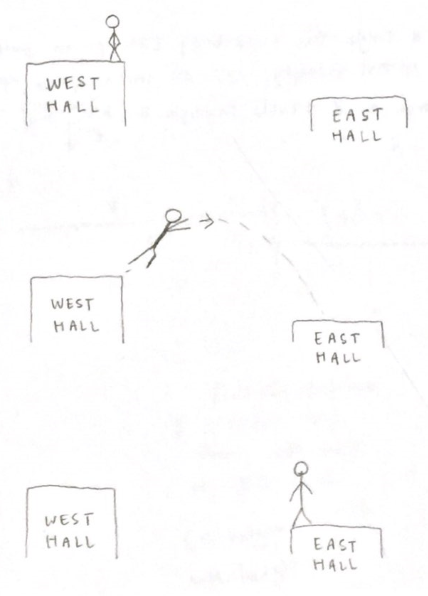

In [34]:
Image("images/jumpingOliner.PNG")

Figure 1: What a jump between West Hall and East Hall might look like. This image is slightly inaccurate because it portrays East Hall as being shorter than West Hall.

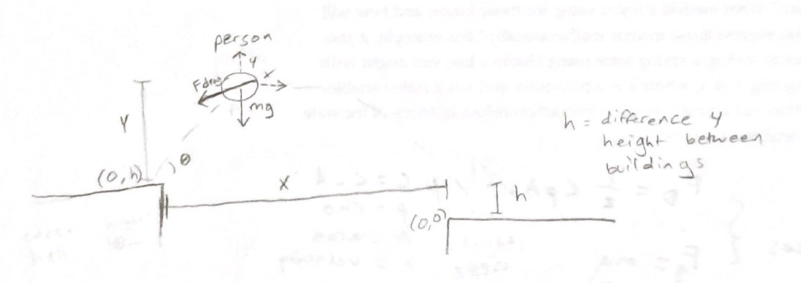

In [35]:
Image("images/olinLaunchSchematic.PNG")

Figure 2: A schematic diagram of the jump between West Hall and East Hall. This diagram has the same error as the first image, but it shows the correct forces that will go into our model.

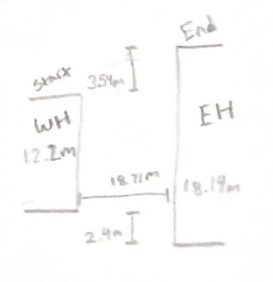

In [36]:
Image("images/olinLaunchDimensions.PNG")

Figure 3: A sketch displaying the dimensions of West Hall and East Hall. These dimensions were found using the original Olin campus blueprints and by hand-measuring certain distances.

## Model

### Setup

First, we need to import all the units we’ll be implementing in the model. We’ll be using the metric system.

In [2]:
m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram
degree = UNITS.degree;

Next, we’ll implement some values for our model. According to campus blueprints, the roof of West Hall is about 12.2 meters off the ground, so we’ll set the starting position of our Oliner at 0 meters out horizontally (x) and 12.2 meters up (y). We’ll also pass in some general constants for use in our equations later on, such as the acceleration due to gravity (g), the average mass of a human being (mass), the average diameter of a curled-up human being (diameter), the density of air (rho), and the drag coefficient of a sphere (C_d). These constants were sourced from either taking actual measurements or online research. Then, We’ll set initial values for our launch angle (angle), and our launch velocity (velocity). Lastly, we’ll set a stop time for the simulation (t_end).

In [3]:
params = Params(x = 0 * m,
                y = 12.2 * m,
                g = 9.8 * m/s**2, 
                mass = 70 * kg,
                diameter = 0.711 * m, 
                rho = 1.2 * kg/m**3, 
                C_d = 0.47,
                angle = 45 * degree,
                velocity = 40 * m / s,
                t_end = 20 * s);

This function takes in our parameters and outputs a system object with our parameters, an initial state for our model, and the area of the facade of our Oliner.

In [28]:
def make_system(params):
    """Make a system object.
    
    params: Params object with angle, velocity, x, y,
               diameter, duration, g, mass, rho, and C_d
               
    returns: System object
    """
    unpack(params)
    
    theta = np.deg2rad(angle)
    
    vx, vy = pol2cart(theta, velocity)
    
    init = State(x=x, y=y, vx=vx, vy=vy)
    
    area = np.pi * (diameter/2)**2
    
    return System(params, init=init, area=area)

This function takes in a velocity and a system object and outputs a vector describing the drag force on our Oliner at any point. The magnitude of this force is computed using the equation magnitude = -(rho * velocity^2 * C_d * area) / 2. Its direction is the same as that of the velocity vector. We make the magnitude negative because the force goes in the opposite direction of our Oliner.

In [26]:
def drag_force(V, system):
    """Computes drag force in the opposite direction of `V`.
    
    V: velocity
    system: System object with rho, C_d, area
    
    returns: Vector drag force
    """
    unpack(system)
    mag = -rho * V.mag**2 * C_d * area / 2
    direction = V.hat()
    f_drag = mag * direction
    return f_drag

This function takes in a state, a time, and a system and outputs changes to each of our state variables, which are the Oliner’s x position, the Oliner’s y position, the Oliner’s velocity in the x direction, and the Oliner’s velocity in y direction. Changes to the Oliner’s x and y positions are simply computed using the corresponding velocity. Changes to the Oliner’s x and y velocities are a little more complex, because we must first compute acceleration. According to the force equation F = mass * acceleration, we can find the acceleration of the Oliner’s x velocity by computing the drag force on the Oliner (using the function `drag_force`) and then dividing it by the Oliner’s mass. To find the acceleration of the Oliner’s y velocity, we simply create a vector with the magnitude of acceleration due to gravity, going straight down.

In [6]:
def slope_func(state, t, system):
    """Computes derivatives of the state variables.
    
    state: State (x, y, x velocity, y velocity)
    t: time
    system: System object with g, rho, C_d, area, mass
    
    returns: sequence (vx, vy, ax, ay)
    """
    x, y, vx, vy = state
    unpack(system)

    V = Vector(vx, vy)    
    a_drag = drag_force(V, system) / mass
    a_grav = Vector(0, -g)
    
    a = a_grav + a_drag
    
    return vx, vy, a.x, a.y

### Finding the optimal angle

In order to figure out the optimal angle for launch, we used `range_func` and `event_func_range`. `range_func` calculates the final x position of the Oliner based on angle and `event_func_range` stops the simulation when the Oliner hits the roof of East Hall. The optimal angle is found by doing a sweep of all angles, and finding the angle that results in the greatest final x position of the Oliner.

In [7]:
system = make_system(params);

`event_func_range` stops the simulation when the Oliner hits the roof of East Hall (15.74m). The direction of `event_func_range` is set to -1 to make sure the simulation does not stop at the beginning of the trajectory when the Oliner is being launched higher but passes the 15.74m y position. 

In [27]:
def event_func_range (state, t, system):
    """Stop when the y coordinate is 15.74m.
    
    state: State object
    t: time
    system: System object
    
    returns: y coordinate - 15.74m
    """
    x, y, vx, vy = state
    return y - 15.74 * m

event_func_range.direction = -1
event_func_range(system.init, 0, system)

<Quantity(-3.540000000000001, 'meter')>

`range_func` calculates the final x position of the Oliner for a given angle.

In [9]:
def range_func(angle, params):  
    """Computes range for a given launch angle.
    
    angle: launch angle in degrees
    params: Params object
    
    returns: distance in meters
    """
    params_range = Params(params, angle=angle)
    system_range = make_system(params_range)
    results, details = run_ode_solver(system_range, slope_func, events=event_func_range)
    x_dist = get_last_value(results.x) * m
    return x_dist

range_func(45 * degree, params)

<Quantity(133.3105526017006, 'meter')>

An array of possible angles is used to create a SweepSeries of angle and corresponding final x position of Oliner. The SweepSeries is then plotted to demonstrate the relationship between launch angle and x distance. In the angles between 0 and 15 degrees, the Oliner falls short of the roof of East Hall, so those angles were taken off the graph for plot clarity.

In [10]:
angles_range = linspace(15, 90, 30)
sweep_range = SweepSeries()

for angle in angles_range:
    x_dist = range_func(angle, params)
    sweep_range[angle] = x_dist

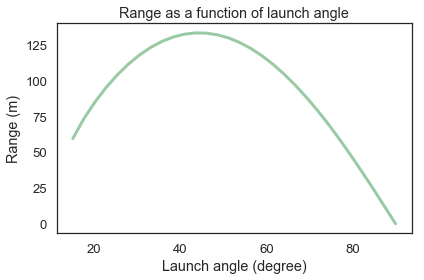

In [11]:
plot(sweep_range, color = 'C2')
decorate(xlabel='Launch angle (degree)',
         ylabel='Range (m)',
         title='Range as a function of launch angle',
         legend=False)

The function `max_bounded` is used to find the the highest x distance based on angle without having to do an entire SweepSeries. The optimal angle is shown to be 44.38 degrees.

In [12]:
results_range = max_bounded(range_func, [0, 90], params)
optimal_angle = results_range.x
print(optimal_angle, results_range.fun)

44.383520474811235 133.3402263522255 meter


Since the x distance is well past 18.71m distance between West Hall and East Hall, the velocity can then be decreased to find the minimum effort possible.

### Height Func

We used `height_func` to track the final height of the Oliner to find the minimum velocity needed to land on East Hall roof (15.74m high).


In [13]:
system = make_system(params);

For `event_func_height`, the termination event is set at the x distance 20 meters. Although the distance between West Hall and East Hall is 18.71m, we wanted to ensure they landed squarely on the roof and not the edge of it. 

In [14]:
def event_func_height(state, t, system):
    """Stop when the x coordinate is 20m.
    
    state: State object
    t: time
    system: System object
    
    returns: x coordinate - 20m
    """
    x, y, vx, vy = state
    return x - 20 * m

event_func_height(system.init, 0, system)

<Quantity(-20, 'meter')>

`height_func` calculates the final height of the Oliner for a given angle.

In [15]:
def height_func(angle, params):  
    """Computes range for a given launch angle.
    
    angle: launch angle in degrees
    params: Params object
    
    returns: distance in meters
    """
    params_height = Params(params, angle=angle)
    system_height = make_system(params_height)
    results, details = run_ode_solver(system_height, slope_func, events=event_func_height)
    y_dist = get_last_value(results.y) * m
    return y_dist

height_func(45 * degree, params)

<Quantity(29.676840050004998, 'meter')>

`height_func` will be used in the next section to find the minimum velocity.

### Finding the minimum velocity

The next part of our solution is to find the minimum velocity needed to clear the jump.

Since we just found the optimal angle for range, we'll now re-establish our parameters, replacing the initial angle value with the one we just found.

In [16]:
params_min = Params(x = 0 * m,
                y = 12.2 * m, 
                g = 9.8 * m/s**2,
                mass = 70 * kg,
                diameter = 0.711 * m, 
                rho = 1.2 * kg/m**3, 
                C_d = 0.47, 
                angle = results_range.x * degree, 
                velocity = 40 * m / s, 
                t_end = 20 * s);

In order to ensure that our optimal velocity takes into account the height the Oliner must reach by the end of the jump, we'll make an error function that takes in a velocity and some parameters and outputs the difference between the calculated end height and the ideal end height. The closer the output of this function is to 0, the better the velocity will fit the model. Currently, our error function is designed for the Oliner to land at a height of 16 meters, which is a bit higher than the required height of 15.74 meters. This is to ensure that the Oliner will land with room to spare. 

In [27]:
def error_func_velocity(v, params_min):
    params_min.velocity = v * m/s
    system = make_system(params_min)
    results = max_bounded(height_func, [0, 90], params_min)
    height = results.fun
    return height - 16 * m

error_func_velocity(40, params_min)

<Quantity(67.24281421116903, 'meter')>

Next, we'll use `fsolve` to find the minimum velocity that our Oliner will need to be launched at.

In [28]:
min_v_array = fsolve(error_func_velocity, 40, params_min)
min_v = min_v_array[0]

15.597622461900539

When we run `error_func` with the value you found.

In [20]:
error_func_velocity(min_v, params_min)

<Quantity(-1.6910917111090384e-12, 'meter')>

## Results

After finding the optimal angle and minimum starting velocity, we made used those values for angle and velocity in final params. Final params will then be used to run one last simulation for the Oliner Launch, to see if these values would have the correct trajectory.

In [21]:
params_final = Params(x = 0 * m, 
                y = 12.2 * m,
                g = 9.8 * m/s**2, 
                mass = 70 * kg, 
                diameter = 0.711 * m,
                rho = 1.2 * kg/m**3, 
                C_d = 0.47, 
                angle = optimal_angle * degree, 
                velocity = min_v * m / s, 
                t_end = 20 * s);

In [22]:
system_final = make_system(params_final);

The final event func stops the simulation when the Oliner hits the roof of East Hall, which is 15.74 meters tall.

In [23]:
def event_func_final(state, t, system):
    """Stop when the y coordinate is 15.74.
    
    state: State object
    t: time
    system: System object
    
    returns: y coordinate
    """
    x, y, vx, vy = state
    return y - 15.74 * m

The event func has its direction set to -1 to make sure the launch is not stopped on the Oliner's way up, but only when they are landing. `run_ode_solver` is run with `event_func_final` and system and then the trajectory of the Oliner is plotted (their x and y position).

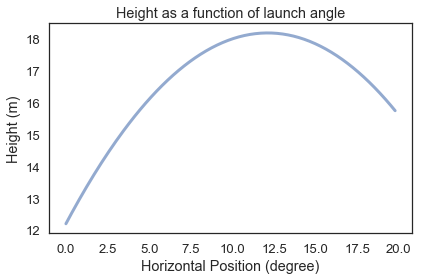

In [24]:
event_func_final.direction = -1
results, details = run_ode_solver(system_final, slope_func, events=event_func_final, max_step=0.01)
plot(results.x, results.y)
decorate(xlabel='Horizontal Position (degree)',
         ylabel='Height (m)',
         title='Height as a function of launch angle',
         legend=False)

In [25]:
final_x = get_last_value(results.x)
final_y = get_last_value(results.y)
print(final_x, final_y)

19.773506256223015 15.74


As shown by the graph and the final x and y position of the Oliner, the launch trajectory is correct. With an optimal angle of 50.44 degrees and a minimum velocity of 15.27 m/s, the Oliner lands 0.5 meters past the required horizontal distance (18.71m) and on the roof of East Hall (15.74m).

## Interpretation

So, in summation, an Oliner with a diameter of 0.711 m and a weight of 70 kg would have to be launched at an angle of 44.38° and a velocity of approximately 15.6 m/s in order to comfortably clear the jump between West Hall and East Hall.

Our model was successful in the way we hoped it’d be and seemed not to have any specific failings. Initially, the majority of our code was based on the Manny Ramirez problem from Chapter 23. However, we ran into an issue with our event function for our range calculations– we found that the model was being stopped at the beginning of the trajectory when the Oliner was being launched higher but passed the 15.74m y position. To solve this problem, we simply implemented a directional event function that only activated the termination event when the Oliner was traveling downwards. 

One shortcoming of our model was that we assumed average measurements for the weight and diameter of our Oliner. Additionally, we assumed that the Oliner would be launched in a perfect ball, when in reality, people cannot be spherical. We also didn’t take into account the safety of our Oliner or the plausibility of a launch between the roofs of West Hall and East Hall, so the scope of our model is rather unrealistic. 

Overall, it is our belief that this model is pretty baller, so to speak. 